<a href="https://colab.research.google.com/github/donthomas6108/Flexible-Beam-Control-Simulation/blob/main/Flexible_beam_control_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/scipy/signal/_filter_design.py:1230: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


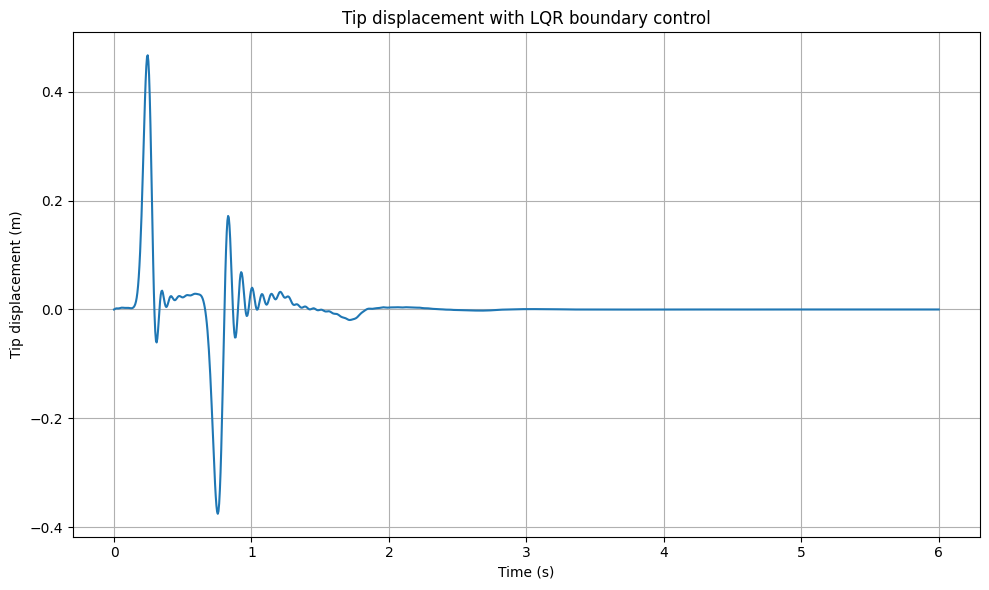

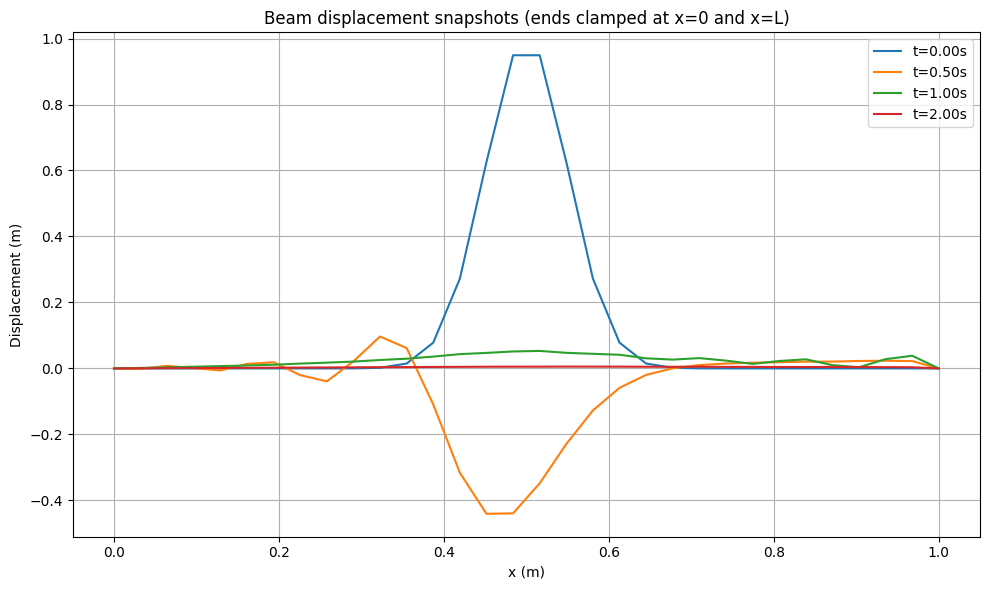

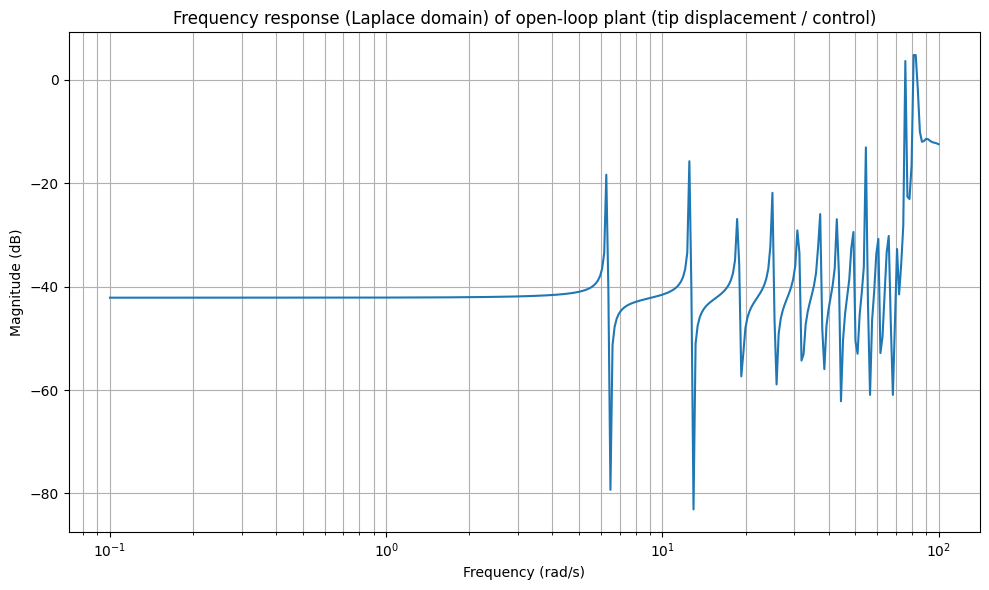

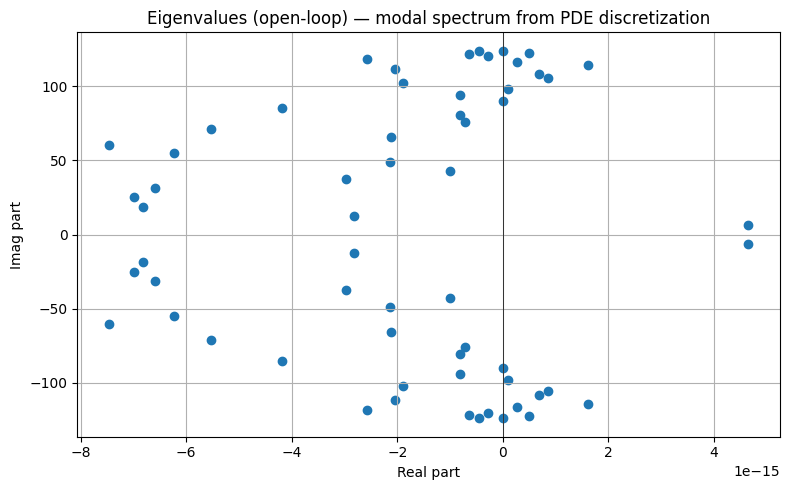


Simulation summary:
  Spatial nodes (interior): 30, dx = 0.0323 m
  State dimension: 60
  LQR gain shape: (1, 60)
  Smallest magnitude eigenvalues (real parts): [ 6.28049694  6.28049694 12.54487193 12.54487193 18.77704441 18.77704441]

Notes:
 - This script ties together: PDE discretization (finite differences), linear algebra (A,B matrices),
   Laplace-domain analysis via state-space -> frequency response, and optimization via LQR (Riccati).
 - Tweak N (spatial resolution), Q/R weights, or the control location in b[] to explore behavior.


In [ ]:
"""
flexible_beam_wave_lqr.py

A self-contained simulation (Python) demonstrating:
- PDE: 1D wave equation (flexible beam) discretized by finite differences
- Linear algebra: assembly of state-space matrices
- Laplace transforms / transfer function: derive TF from state-space and plot frequency response
- Optimization: design LQR controller to stabilize and control the beam using boundary control

Requirements:
- Python 3.8+
- numpy, scipy, matplotlib

Run:
    python3 flexible_beam_wave_lqr.py

Notes:
- Left boundary (x=0) is clamped (u=0). Right boundary (x=L) receives control force u_c(t).
- The beam is modeled by the 1D wave equation: u_tt = c^2 * u_xx
- Spatial discretization turns PDE into a large ODE: M x'' + K x = B u -> state-space
"""

import numpy as np
import scipy.linalg as la
import scipy.integrate as integrate
import scipy.signal as signal
import matplotlib.pyplot as plt

# ----------------------- Simulation parameters -----------------------
L = 1.0         # length of beam (m)
N = 30          # number of internal spatial points (higher -> better PDE resolution)
c = 2.0         # wave speed
rho = 1.0       # density (mass per unit length)

# Discretization
dx = L / (N + 1)            # grid spacing; exclude boundaries
x = np.linspace(dx, L-dx, N)  # interior points

# Second derivative finite difference matrix (Dirichlet at left, Neumann/control at right handled separately)
D2 = np.zeros((N, N))
for i in range(N):
    if i > 0:
        D2[i, i-1] = 1.0
    D2[i, i] = -2.0
    if i < N-1:
        D2[i, i+1] = 1.0
D2 = D2 / (dx**2)

# For the wave equation u_tt = c^2 u_xx, we can write in semi-discrete form: u_tt = c^2 D2 u + b * u_control
# We'll apply control at the right-most interior node as a Neumann-like forcing: approximate by adding a control vector.
b = np.zeros((N, 1))
b[-1, 0] = 1.0 / (rho*dx)   # scaling to approximate boundary forcing -> affects last node

# State-space assembly: define state z = [u; v] where v = u_t
# u' = v
# v' = c^2 D2 u + b * u_control
A_top = np.hstack([np.zeros((N, N)), np.eye(N)])
A_bottom = np.hstack([c**2 * D2, np.zeros((N, N))])
A = np.vstack([A_top, A_bottom])

B = np.vstack([np.zeros((N, 1)), b])

# Output: we may be interested in displacement at the tip (last node)
C = np.zeros((1, 2*N))
C[0, N-1] = 1.0  # measure displacement at last interior node
D = np.zeros((1, 1))

# ----------------------- Laplace transform / Transfer function -----------------------
# We can compute the transfer function from control u_c to tip displacement using state-space -> transfer function (Laplace variable s)
# scipy.signal.ss2tf returns numerator(s) and denominator
num, den = signal.ss2tf(A, B, C, D)
# num shape: (outputs, inputs, degree+1) flattened as (outputs, degree+1) per input; for SISO num[0] is array
num = num[0]  # outputs dimension
# Convert to 1D arrays for easier use (SISO)
num_siso = num.flatten()
den_siso = den

# ----------------------- LQR (optimization) design -----------------------
# Continuous-time LQR: minimize integral(x'Qx + u'R u) dt
# Use scipy.linalg.solve_continuous_are to get P, then K = R^{-1} B^T P
Q = la.block_diag(100*np.eye(N), 1*np.eye(N))  # penalize displacement strongly
R = np.array([[0.1]])                          # penalize control effort

# Solve CARE
P = la.solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @ B.T @ P

# Closed-loop system matrix
A_cl = A - B @ K

# ----------------------- Simulation (time-domain) -----------------------
# simulate an initial displacement (e.g., a Gaussian at mid-span) and see LQR stabilization
u0 = np.exp(-200*(x - 0.5*L)**2)  # initial displacement
v0 = np.zeros_like(u0)
z0 = np.concatenate([u0, v0])

t_final = 6.0
t_eval = np.linspace(0, t_final, 1201)

# We'll simulate closed-loop dynamics: z' = (A - B K) z
def closed_loop(t, z):
    # state feedback control u = -K z
    dz = A_cl @ z
    return dz

sol = integrate.solve_ivp(closed_loop, [0, t_final], z0, t_eval=t_eval, method='RK45')

# Tip displacement over time
tip_disp = sol.y[N-1, :]

# ----------------------- Plots -----------------------
plt.figure(figsize=(10, 6))
plt.plot(t_eval, tip_disp)
plt.xlabel('Time (s)')
plt.ylabel('Tip displacement (m)')
plt.title('Tip displacement with LQR boundary control')
plt.grid(True)
plt.tight_layout()

# Plot a few snapshots of the beam shape over time
snap_times = [0.0, 0.5, 1.0, 2.0]
indices = [np.argmin(np.abs(t_eval - st)) for st in snap_times]
plt.figure(figsize=(10, 6))
for idx, ti in zip(indices, snap_times):
    uz = sol.y[:N, idx]
    plt.plot(np.concatenate(([0.0], x, [L])), np.concatenate(([0.0], uz, [0.0])), label=f't={ti:.2f}s')
plt.xlabel('x (m)')
plt.ylabel('Displacement (m)')
plt.title('Beam displacement snapshots (ends clamped at x=0 and x=L)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Frequency response (Laplace domain analysis) via transfer function magnitude
w = np.logspace(-1, 2, 400)
# use freqresp from state-space; building TF is sometimes numerically sensitive for large A, so use freqresp with the ss system
sys = signal.StateSpace(A, B, C, D)
wout, mag, phase = signal.bode(sys, w)

plt.figure(figsize=(10, 6))
plt.semilogx(wout, mag)
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency response (Laplace domain) of open-loop plant (tip displacement / control)')
plt.grid(True, which='both')
plt.tight_layout()

# Eigenvalues (modal analysis) — linear algebra + PDE connection
eigvals, eigvecs = la.eig(A)
plt.figure(figsize=(8, 5))
plt.scatter(eigvals.real, eigvals.imag)
plt.xlabel('Real part')
plt.ylabel('Imag part')
plt.title('Eigenvalues (open-loop) — modal spectrum from PDE discretization')
plt.axvline(0, color='k', linewidth=0.5)
plt.grid(True)
plt.tight_layout()

plt.show()

# ----------------------- Print summary info -----------------------
print('\nSimulation summary:')
print(f'  Spatial nodes (interior): {N}, dx = {dx:.4f} m')
print(f'  State dimension: {A.shape[0]}')
print(f'  LQR gain shape: {K.shape}')
print(f'  Smallest magnitude eigenvalues (real parts): {np.sort(np.abs(eigvals))[:6]}')

print('\nNotes:')
print(' - This script ties together: PDE discretization (finite differences), linear algebra (A,B matrices),')
print('   Laplace-domain analysis via state-space -> frequency response, and optimization via LQR (Riccati).')
print(' - Tweak N (spatial resolution), Q/R weights, or the control location in b[] to explore behavior.')

# End of file
